In [1]:
import sys
sys.path.append('./')  # Adjust the path based on your project structure
from SCFpyr import SCFpyr
import torch


In [2]:
import os
import numpy as np
import skimage
import matplotlib.pyplot as plt
import torch
import torchvision

################################################################################

ToPIL = torchvision.transforms.ToPILImage()
Grayscale = torchvision.transforms.Grayscale()
RandomCrop = torchvision.transforms.RandomCrop


def load_image(image_file):
    if isinstance(image_file, str):
        if not os.path.isfile(image_file):
            raise FileNotFoundError('Image file not found on disk: {}'.format(image_file))
        im = ToPIL(skimage.io.imread(image_file))
    else:
        im = image_file
    im = Grayscale(im)
    
    image_size = im.size
    
    im_batch = np.zeros((1, 1, image_size[1], image_size[0]), np.float32)        
    im_batch[0,0,:,:] = im
    # insert channels dim and rescale
    return im_batch[:,:,:,:]/225.

/home/jonathanalis/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/jonathanalis/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
############################################################################
# Build the complex steerable pyramid
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pyr = SCFpyr(
    height=7, #levels 
    nbands=8,
    scale_factor=2, 
    device = device
)

############################################################################
# Create a batch and feed-forward
im_batch_numpy = load_image('./data/lena.jpg')

im_batch_torch = torch.from_numpy(im_batch_numpy).to(device)
import torch.nn.functional as F
output_height, output_width = 128,173
output_height, output_width = 512,600
im_batch_torch = F.interpolate(im_batch_torch, 
                               size=(output_height, output_width), 
                               mode='bilinear', 
                               align_corners=False)

im_batch_torch = im_batch_torch.repeat(5, 1, 1, 1)
print(im_batch_torch.shape)
print(im_batch_numpy.shape)


torch.Size([5, 1, 512, 600])
(1, 1, 600, 600)


In [4]:
coeffs = pyr.build(im_batch_torch)
pyr.summary(coeffs)

Levels:  5
Height:  7
Num bands:  8
Scale factor:  2
torch.Size([5, 512, 600]) <class 'torch.Tensor'>
Level 1:
torch.Size([5, 512, 600]) <class 'torch.Tensor'>, torch.Size([5, 512, 600]) <class 'torch.Tensor'>, torch.Size([5, 512, 600]) <class 'torch.Tensor'>, torch.Size([5, 512, 600]) <class 'torch.Tensor'>, torch.Size([5, 512, 600]) <class 'torch.Tensor'>, torch.Size([5, 512, 600]) <class 'torch.Tensor'>, torch.Size([5, 512, 600]) <class 'torch.Tensor'>, torch.Size([5, 512, 600]) <class 'torch.Tensor'>, 
Level 2:
torch.Size([5, 256, 300]) <class 'torch.Tensor'>, torch.Size([5, 256, 300]) <class 'torch.Tensor'>, torch.Size([5, 256, 300]) <class 'torch.Tensor'>, torch.Size([5, 256, 300]) <class 'torch.Tensor'>, torch.Size([5, 256, 300]) <class 'torch.Tensor'>, torch.Size([5, 256, 300]) <class 'torch.Tensor'>, torch.Size([5, 256, 300]) <class 'torch.Tensor'>, torch.Size([5, 256, 300]) <class 'torch.Tensor'>, 
Level 3:
torch.Size([5, 128, 150]) <class 'torch.Tensor'>, torch.Size([5, 128,

In [5]:
rec = pyr.reconstruct(coeffs)

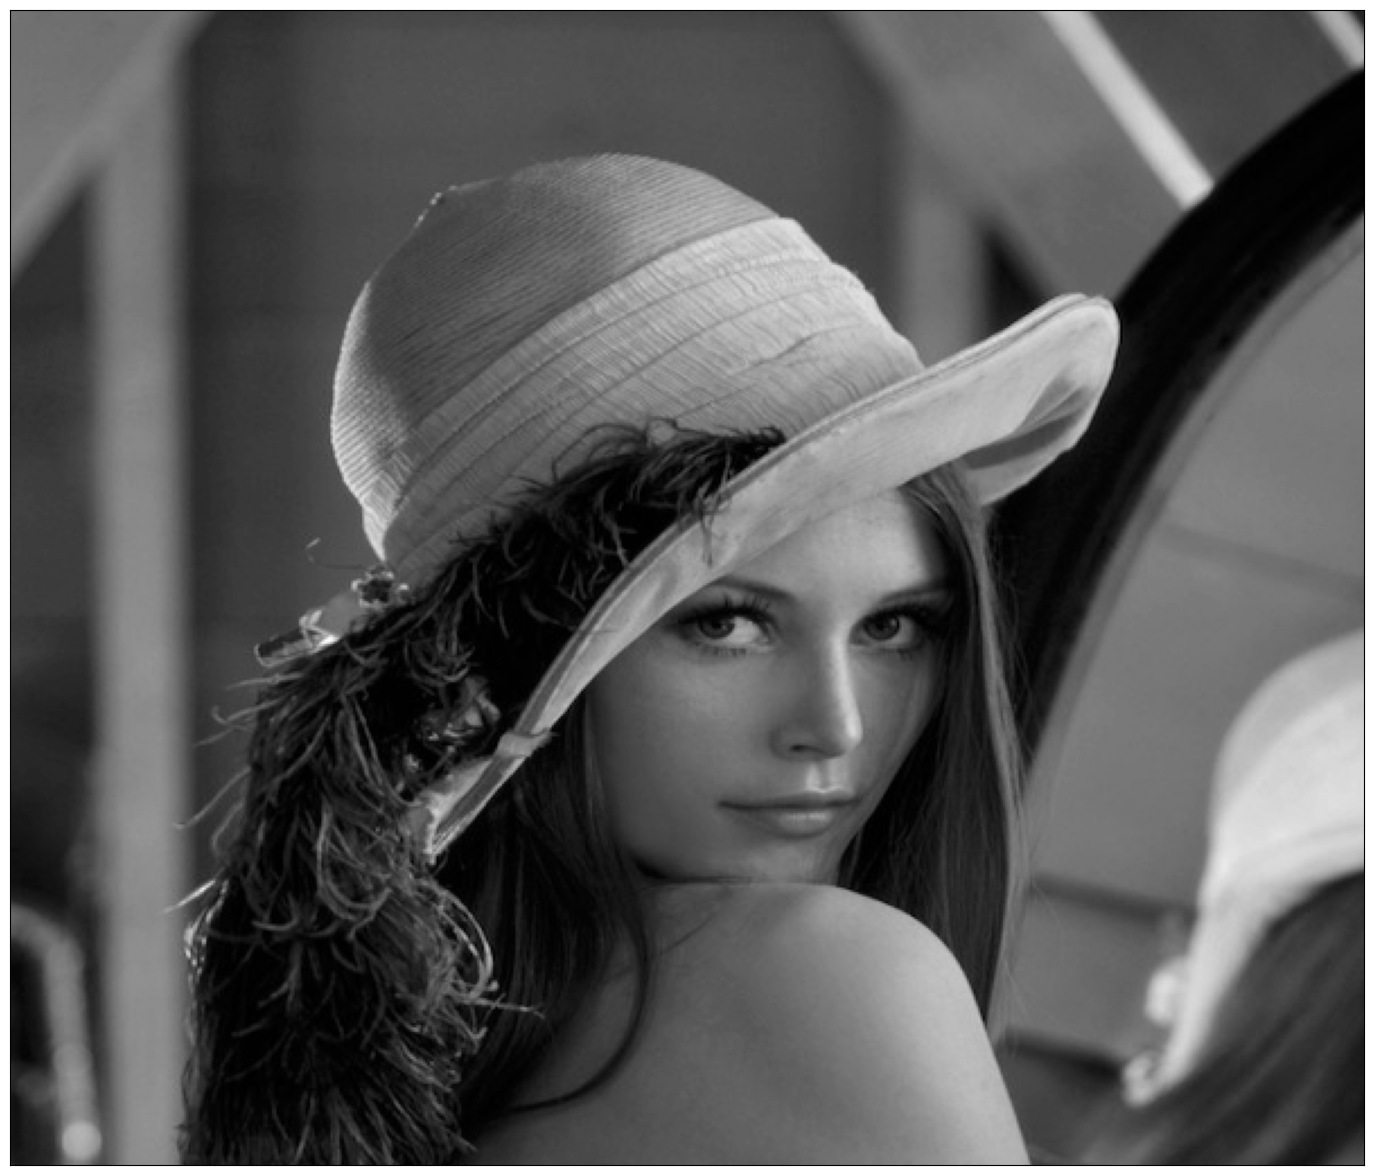

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.imshow(rec[4,:,:], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()


/home/jonathanalis/.local/lib/python3.10/site-packages/torch/_tensor.py:1064: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


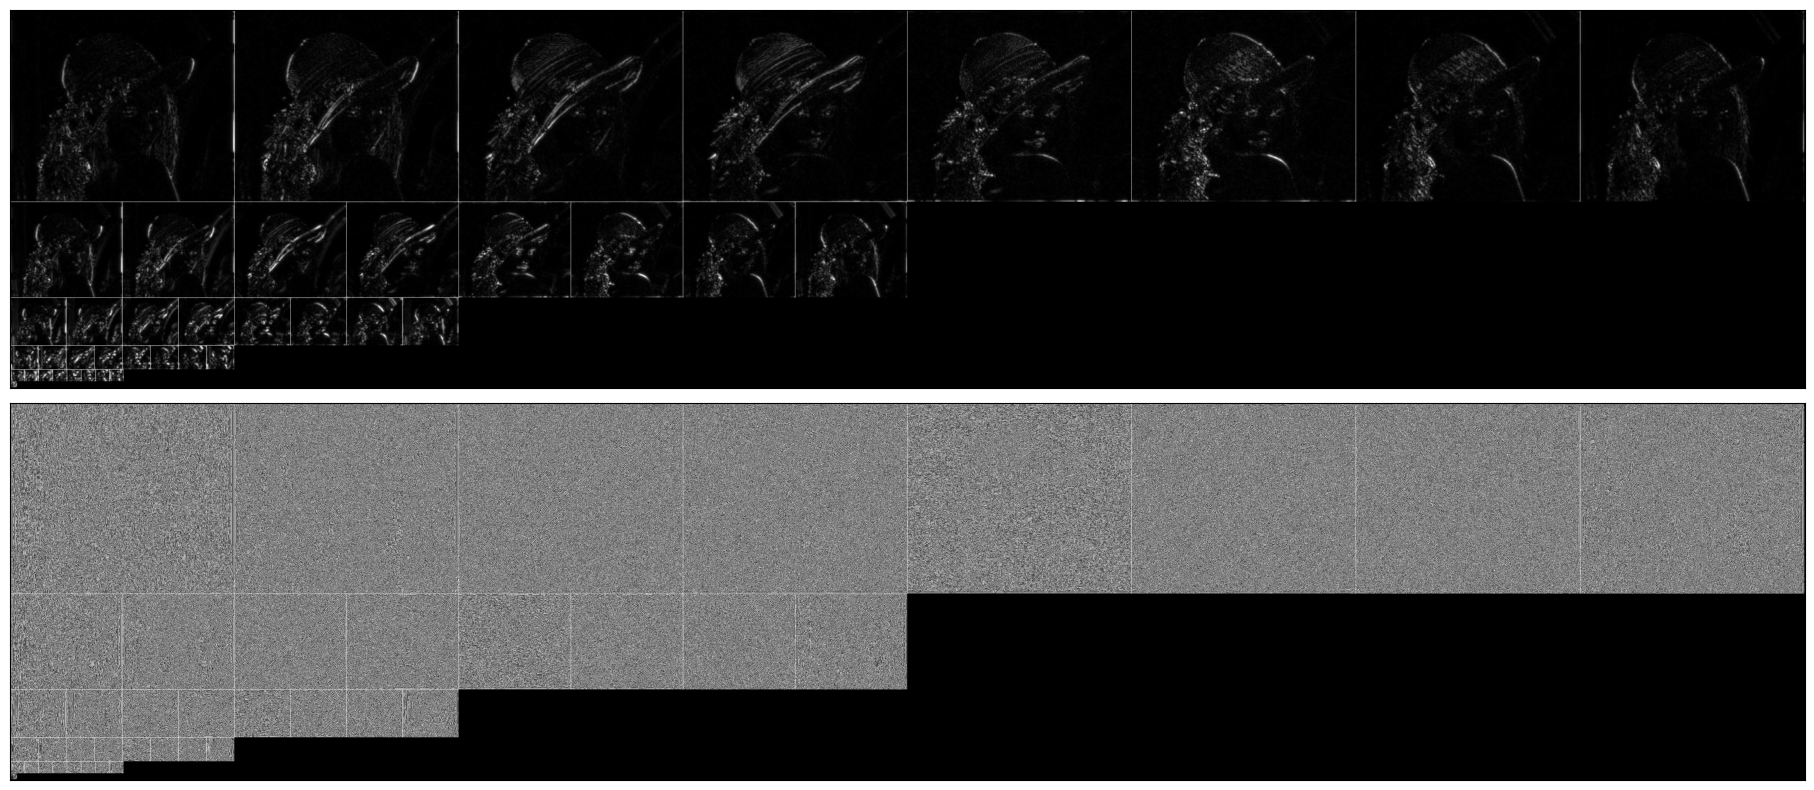

In [7]:
#coeff_grid_real = pyr.view_coeff(coeffs, part = 'real', normalize=True)
#coeff_grid_imag = pyr.view_coeff(coeffs, part = 'imag', normalize=True)
coeff_grid_mag = pyr.view_coeff(coeffs, part = 'mag', normalize=True)
coeff_grid_phase = pyr.view_coeff(coeffs, part = 'phase', normalize=True)

num_plots = 2
aspect_ratio = coeff_grid_phase.shape[1]/coeff_grid_phase.shape[0]
fig, axs = plt.subplots(num_plots, 1, figsize=(20, int(num_plots*20/aspect_ratio)))
axs[0].imshow(coeff_grid_mag, cmap='gray')
axs[1].imshow(coeff_grid_phase, cmap='gray')
#axs[2].imshow(coeff_grid_real, cmap='gray')
#axs[3].imshow(coeff_grid_imag, cmap='gray')
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()


In [8]:
import cv2
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np

class VideoDataset(Dataset):
    def __init__(self, video_path, transform=None):
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)
        self.transform = transform

    def __len__(self):
        return int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))

    def __getitem__(self, idx):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = self.cap.read()
        if not ret:
            raise IndexError("End of video reached or bad frame index")

        # Convert frame to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if self.transform:
            frame_gray = self.transform(frame_gray)

        return frame_gray

# Define a transform to convert the frames to PyTorch tensors
class ToTensor(object):
    def __call__(self, frame):
        return torch.from_numpy(frame).unsqueeze(0).float()


# Parameters
video_path = "data/subway.mp4"
batch_size = 4

# Create dataset and DataLoader
video_dataset = VideoDataset(video_path, transform=ToTensor())
video_loader = DataLoader(video_dataset, batch_size=batch_size, shuffle=True)



In [9]:
pyr = SCFpyr(
    height=3, #levels 
    nbands=4,
    scale_factor=2, 
    device = device
)


In [10]:

# Iterate over batches
for batch in video_loader:
    # batch is a tensor with shape (batch_size, channels, height, width)
    print("Batch shape:", batch.shape)
    coeffs = pyr.build(batch)
    pyr.summary(coeffs)
    # You can do further processing or use the batches for training or inference


Batch shape: torch.Size([4, 1, 352, 640])
Levels:  1
Height:  3
Num bands:  4
Scale factor:  2
torch.Size([4, 352, 640]) <class 'torch.Tensor'>
Level 1:
torch.Size([4, 352, 640]) <class 'torch.Tensor'>, torch.Size([4, 352, 640]) <class 'torch.Tensor'>, torch.Size([4, 352, 640]) <class 'torch.Tensor'>, torch.Size([4, 352, 640]) <class 'torch.Tensor'>, 
torch.Size([4, 176, 320])
<class 'torch.Tensor'>
Batch shape: torch.Size([4, 1, 352, 640])
Levels:  1
Height:  3
Num bands:  4
Scale factor:  2
torch.Size([4, 352, 640]) <class 'torch.Tensor'>
Level 1:
torch.Size([4, 352, 640]) <class 'torch.Tensor'>, torch.Size([4, 352, 640]) <class 'torch.Tensor'>, torch.Size([4, 352, 640]) <class 'torch.Tensor'>, torch.Size([4, 352, 640]) <class 'torch.Tensor'>, 
torch.Size([4, 176, 320])
<class 'torch.Tensor'>
Batch shape: torch.Size([4, 1, 352, 640])
Levels:  1
Height:  3
Num bands:  4
Scale factor:  2
torch.Size([4, 352, 640]) <class 'torch.Tensor'>
Level 1:
torch.Size([4, 352, 640]) <class 'torch.T

In [11]:
writer = None
output_video_path = "data/test.mp4"
# Iterate over batches
for batch in video_loader:
    coeffs = pyr.build(batch)
    frames_np = batch.squeeze(1).numpy().astype(np.uint8)
    frames_rgb = np.stack((frames_np,) * 3, axis=-1)

    for i in range(frames_rgb.shape[0]):
        abs = pyr.view_coeff(coeffs, part = 'mag', normalize=True, frame = i)
        phase = pyr.view_coeff(coeffs, part = 'phase', normalize=True, frame = i)
        #real = pyr.view_coeff(coeffs, part = 'real', normalize=True, frame = i)
        #imag = pyr.view_coeff(coeffs, part = 'imag', normalize=True, frame = i)
        
        both = np.vstack((abs, phase))#, real, imag))
        # Initialize video writer
        if writer is None: #primeira vez
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            height, width = both.shape[:2]
            writer = cv2.VideoWriter(output_video_path, fourcc, 30, (width, height))

        rgb = np.stack((both,) * 3, axis=-1)
        writer.write(rgb)

# Release video writer
if writer is not None:
    writer.release()
